In [1]:
import numpy as np
from wrf import (to_np, getvar, smooth2d, get_cartopy, cartopy_xlim,
                 cartopy_ylim, latlon_coords, interplevel, ll_to_xy)
import matplotlib.pyplot as plt
from netCDF4 import Dataset
from matplotlib.cm import get_cmap
import cartopy.crs as crs
from cartopy.feature import NaturalEarthFeature
import xarray as xr
import gc, glob
import pickle
from tqdm import tqdm
from scipy import ndimage

In [2]:
import sys
sys.path.insert(1, '../../')
from util.ml import (preproc)
from util.wrf_process import (read_and_write,calc_derive,object_tracking)
import read_config

In [9]:
exptype=str(9100)
startname=12
sorted(glob.glob(f'../../storage/proc/Xsmooth/{exptype}/Xtimeseries*pkl'))[0].split('/')[-1][int(startname):].split('.')[0]

'0_3'

In [10]:
sorted(glob.glob(f'../../storage/proc/Xsmooth/{exptype}/Xtimeseries*pkl'))

['../../storage/proc/Xsmooth/9100/Xtimeseries_0_3.pkl',
 '../../storage/proc/Xsmooth/9100/Xtimeseries_0_6.pkl',
 '../../storage/proc/Xsmooth/9100/Xtimeseries_0_9.pkl',
 '../../storage/proc/Xsmooth/9100/Xtimeseries_1_3.pkl',
 '../../storage/proc/Xsmooth/9100/Xtimeseries_1_5.pkl',
 '../../storage/proc/Xsmooth/9100/Xtimeseries_1_6.pkl',
 '../../storage/proc/Xsmooth/9100/Xtimeseries_1_7.pkl',
 '../../storage/proc/Xsmooth/9100/Xtimeseries_2_0.pkl',
 '../../storage/proc/Xsmooth/9100/Xtimeseries_2_4.pkl',
 '../../storage/proc/Xsmooth/9100/Xtimeseries_2_6.pkl',
 '../../storage/proc/Xsmooth/9100/Xtimeseries_2_9.pkl',
 '../../storage/proc/Xsmooth/9100/Xtimeseries_3_7.pkl',
 '../../storage/proc/Xsmooth/9100/Xtimeseries_4_7.pkl',
 '../../storage/proc/Xsmooth/9100/Xtimeseries_5_0.pkl',
 '../../storage/proc/Xsmooth/9100/Xtimeseries_5_9.pkl',
 '../../storage/proc/Xsmooth/9100/Xtimeseries_6_4.pkl',
 '../../storage/proc/Xsmooth/9100/Xtimeseries_7_2.pkl',
 '../../storage/proc/Xsmooth/9100/Xtimeseries_9_

# Read processed files

In [ ]:
Upol,Vpol = [],[]
for memb in [1,2,3,4,5,6,7,8,9,10]:
    if memb<10:
        Upol.append(read_and_write.depickle(sorted(glob.glob(f'../../storage/memb0{memb}/proc/cutpol_U.pkl'))[0]))
        Vpol.append(read_and_write.depickle(sorted(glob.glob(f'../../storage/memb0{memb}/proc/cutpol_V.pkl'))[0]))
    else:
        Upol.append(read_and_write.depickle(sorted(glob.glob(f'../../storage/memb{memb}/proc/cutpol_U.pkl'))[0]))
        Vpol.append(read_and_write.depickle(sorted(glob.glob(f'../../storage/memb{memb}/proc/cutpol_V.pkl'))[0]))        

In [3]:
rthratlw,rthratsw=[],[]
for memb in [1,2,3,4,5,6,7,8,9,10]:
    if memb<10:
        rthratlw.append(read_and_write.depickle(sorted(glob.glob(f'../../storage/memb0{memb}/proc/cutcart_rthratlw.pkl'))[0])['pol'])
        rthratsw.append(read_and_write.depickle(sorted(glob.glob(f'../../storage/memb0{memb}/proc/cutcart_rthratsw.pkl'))[0])['pol'])
    else:
        rthratlw.append(read_and_write.depickle(sorted(glob.glob(f'../../storage/memb{memb}/proc/cutcart_rthratlw.pkl'))[0])['pol'])
        rthratsw.append(read_and_write.depickle(sorted(glob.glob(f'../../storage/memb{memb}/proc/cutcart_rthratsw.pkl'))[0])['pol'])

In [4]:
def do_smoothing(f,nx_sm,nx_repeat,nt_smooth):
    rthratlw_smooth = []
    for i in (range(len(f))):
        rthratlw_smooth.append(calc_derive.smooth_var(f[i],nx_sm,nx_repeat,nt_smooth))
    return (rthratlw_smooth)

In [5]:
rthratlw_smooth,rthratsw_smooth=[],[]
for i in tqdm(range(len(rthratlw))):
    rthratlw_smooth.append(do_smoothing(rthratlw[i],9,2,3))
    rthratsw_smooth.append(do_smoothing(rthratsw[i],9,2,3))

del rthratlw,rthratsw
gc.collect()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [02:15<00:00, 13.53s/it]


0

In [12]:
rthratlw_flat,rthratsw_flat = [],[]
for memb in range(len(rthratlw_smooth)):
    rthratlw_flat.append([obj.reshape(-1) for obj in rthratlw_smooth[memb]][:-1])
    rthratsw_flat.append([obj.reshape(-1) for obj in rthratsw_smooth[memb]][:-1])
#del rthratlw,rthratsw
#gc.collect()

# Surface intensity

In [4]:
def get_intensification(U=None,V=None):
    swspd = np.sqrt(np.asarray(U['pol'])[:,0,...]**2+np.asarray(V['pol'])[:,0,...]**2)
    return np.max(np.mean(swspd,axis=2),axis=1)

In [5]:
wspds = [get_intensification(Upol[i],Vpol[i]) for i in range(len(Upol))]
wspddiffs = [np.diff(wspds[i])/(60*60) for i in range(len(wspds))]

In [11]:
[wspddiffobj.shape for wspddiffobj in wspddiffs],[np.asarray(obj).shape for obj in rthratlw_flat]

([(67,), (70,), (68,), (59,), (67,), (67,), (70,), (60,), (70,), (34,)],
 [(67, 6615000),
  (70, 6615000),
  (68, 6615000),
  (59, 6615000),
  (67, 6615000),
  (67, 6615000),
  (70, 6615000),
  (60, 6615000),
  (70, 6615000),
  (34, 6615000)])

In [23]:
Xfiles = glob.glob(f'../../storage/proc/PCA_*.pkl')
for i in range(len(Xfiles)):
    valid1 = Xfiles[i].split('/')[-1].split('.')[0].split('_')[1]
    valid2 = Xfiles[i].split('/')[-1].split('.')[0].split('_')[2]
    ytrain,yvalid,ytest = preproc.train_valid_test(expvarlist=wspddiffs,validindex=[int(valid1),int(valid2)],testindex=[8],concat='Yes')
    read_and_write.save_to_pickle({'train':ytrain,'valid':yvalid,'test':ytest},f'../../storage/proc/y_{int(valid1)}_{int(valid2)}.pkl')

In [17]:
wspds[0].shape,wspddiffs[0].shape

((68,), (67,))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.35it/s]


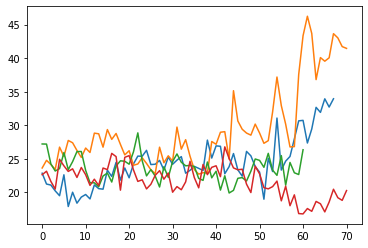

In [43]:
for i in tqdm([5,6,7,8]):#,5,6,7,8]):
    plt.plot(np.max(np.max(np.sqrt(np.asarray(Upol[i]['pol'])[:,0,...]**2+np.asarray(Vpol[i]['pol'])[:,0,...]**2),axis=-1),
                       axis=1))
plt.show()

# Radiation

In [13]:
Xtrain['LW'].shape

(425, 6615000)

In [13]:
import random
from sklearn.decomposition import PCA
from sklearn.decomposition import IncrementalPCA

n_batches=3
n_comps = 140
Xfiles = sorted(glob.glob(f'../../storage/proc/PCA/PCA_*.pkl'))
for i in tqdm([1,2]):#range(20)):
    # Choosing 2 random numbers
    #validindices = random.sample([0,1,2,3,4,5,6,7,9], 2)
    valid1 = Xfiles[i].split('/')[-1].split('.')[0].split('_')[1]
    valid2 = Xfiles[i].split('/')[-1].split('.')[0].split('_')[2]
    validindices = [int(valid1),int(valid2)]
    # Separate data
    Xtrain,Xvalid,Xtest = {},{},{}
    Xtrain['LW'],Xvalid['LW'],Xtest['LW'] = preproc.train_valid_test(expvarlist=rthratlw_flat,validindex=validindices,testindex=[8],concat='Yes')
    Xtrain['SW'],Xvalid['SW'],Xtest['SW'] = preproc.train_valid_test(expvarlist=rthratsw_flat,validindex=validindices,testindex=[8],concat='Yes')
    #del rthratlw_flat,rthratsw_flat
    #gc.collect()
    # Train PCA
    PCAdict = {}
    for ivar in (['LW','SW']):
        inc_pca = IncrementalPCA(n_components=100,copy=False)#int(Xtrain[ivar].shape[0]/n_batches)-1)#n_comps)
        for X_batch in tqdm(np.array_split(Xtrain[ivar],n_batches)):
            inc_pca.partial_fit(X_batch)
    #    PCAdict[ivar]=inc_pca
    # Save stuff    
    #read_and_write.save_to_pickle({'PCA':PCAdict},f'../../storage/proc/PCA/PCAsmooth9153_{validindices[0]}_{validindices[1]}.pkl')
    #read_and_write.save_to_pickle({'train':Xtrain,'valid':Xvalid,'test':Xtest},f'../../storage/proc/X_{validindices[0]}_{validindices[1]}.pkl')
    del PCAdict,Xtrain,Xvalid,Xtest
    gc.collect()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [32:13<00:00, 644.44s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [34:18<00:00, 686.13s/it]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [2:15:29<00:00, 4064.92s/it]


In [13]:
Xtrain['LW'].shape

(461, 6615000)